# Artificial Intelligence– A1(IITJ)
**Prepared by :**
**Mahantesh Hiremath- G24AIT2178**

A.) Dynamic Goal-Based Agent for Warehouse Logistics Optimization.
A robotic agent operates in a warehouse modeled as an N×M grid environment. The agent starts at a predefined loading dock and must deliver packages to multiple destinations marked on the grid while avoiding dynamically placed obstacles.
Take suitable values of the following parameters.
- Warehouse dimensions: N×M grid size (M,N between 5 and 10, inclusive)
- Number of packages: P (between 2 and 6, inclusive)
- Number of obstacles: O (between 1 and 10, inclusive)
- Package locations: (X1, Y1), (X2, Y2), ... (XP, YP)
- Drop-off locations: (D1X, D1Y), (D2X, D2Y), ... (DPX, DPY)
- Robot starting position: S=(Sx,Sy), starts at a fixed cell but moves dynamically
- Movement cost: Each movement incurs a cost of 1 unit
- Delivery reward: Successfully delivering a package adds 10 units to the total reward
- Obstacle penalty: Hitting an obstacle results in a (-5) penalty
Note : Packages locations and drop-off locations should not overlap.




# Q1. Represent the warehouse as an N×M matrix. Place the packages, drop-off points, and obstacles randomly. Display the initial warehouse configuration.


In [95]:
pip install numpy

In [96]:
import numpy as np
import random

def generate_warehouse(N, M, P, O):
    """Generates a random warehouse configuration with icons.

    Args:
        N: Number of rows in the grid.
        M: Number of columns in the grid.
        P: Number of packages.
        O: Number of obstacles.

    Returns:
        A tuple containing:
            - warehouse: A NumPy matrix representing the warehouse.
            - package_locations: A list of tuples, each representing a package location.
            - drop_off_locations: A list of tuples, each representing a drop-off location.
            - obstacle_locations: A list of tuples, each representing an obstacle location.
            - start_position: A tuple representing the robot's starting position.
    """

    warehouse = np.full((N, M), '.', dtype=str)  # Use '.' for empty cells
    package_locations = []
    drop_off_locations = []
    obstacle_locations = []

    # Generate package locations
    while len(package_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations:
            package_locations.append((x, y))
            warehouse[x, y] = 'P'  # 'P' represents a package

    # Generate drop-off locations
    while len(drop_off_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations:
            drop_off_locations.append((x, y))
            warehouse[x, y] = 'D'  # 'D' represents a drop-off point

    # Generate obstacle locations
    while len(obstacle_locations) < O:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations and (x,y) not in obstacle_locations:
            obstacle_locations.append((x, y))
            warehouse[x, y] = 'O'  # 'O' represents an obstacle

    # Starting position (fixed loading dock, let's say (0, 0))
    start_position = (0, 0)
    warehouse[0, 0] = 'S' # 'S' represents robot starting point.

    return warehouse, package_locations, drop_off_locations, obstacle_locations, start_position

# Set parameters
N = random.randint(5, 10)
M = random.randint(5, 10)
P = random.randint(2, 6)
O = random.randint(1, 10)

# Generate the warehouse
warehouse, package_locations, drop_off_locations, obstacle_locations, start_position = generate_warehouse(N, M, P, O)

# Display the warehouse
print("Warehouse Configuration:")
print  ("""
===============================
N: Number of rows in the grid.
M: Number of columns in the grid.
P: Number of packages.
O: Number of obstacles.
.: for empty cells 
==================================""")

for row in warehouse:
    print(' '.join(row))
print  ("""==================================""")
print("N =", N, "M =", M)
print("Packages:", package_locations)
print("Drop-off locations:", drop_off_locations)
print("Obstacle locations:", obstacle_locations)
print("Start Position:", start_position)




Warehouse Configuration:

N: Number of rows in the grid.
M: Number of columns in the grid.
P: Number of packages.
O: Number of obstacles.
.: for empty cells 
S . . . . . . .
. . . P . . . .
. . . . . . . .
P . . . . . . O
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . D . . D .
N = 9 M = 8
Packages: [(1, 3), (3, 0)]
Drop-off locations: [(8, 3), (8, 6)]
Obstacle locations: [(3, 7)]
Start Position: (0, 0)


# Q2. Implement a goal-based agent that can identify all goals, plan a sequence of actions to reach the goal, use a search algorithm (BFS, DFS, or UCS) to find optimal paths, deliver all packages, and calculate the total cost.

In [97]:
import numpy as np
import random
from collections import deque
import heapq

class WarehouseAgent:
    def __init__(self, warehouse, package_locations, drop_off_locations, obstacle_locations, start_position, seed):
        """
        Initializes the WarehouseAgent.

        Args:
            warehouse (numpy.ndarray): The warehouse grid.
            package_locations (list): List of package locations.
            drop_off_locations (list): List of drop-off locations.
            obstacle_locations (list): List of obstacle locations.
            start_position (tuple): The starting position of the agent.
            seed (int): Random seed for reproducibility.
        """
        self.warehouse = warehouse
        self.package_locations = package_locations
        self.drop_off_locations = drop_off_locations
        self.obstacle_locations = obstacle_locations
        self.start_position = start_position
        self.current_position = start_position
        self.packages_carried = []
        self.total_cost = 0
        self.total_reward = 0
        self.path_taken = []
        self.seed = seed
        # Create a mapping of package locations to drop-off locations
        self.package_to_dropoff = dict(zip(package_locations, drop_off_locations))
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_neighbors(self, position):
        """Returns valid neighboring positions."""
        x, y = position
        neighbors = []
        possible_moves = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
        for nx, ny in possible_moves:
            if 0 <= nx < self.warehouse.shape[0] and 0 <= ny < self.warehouse.shape[1] and self.warehouse[nx, ny] != 'O':
                neighbors.append((nx, ny))
        return neighbors

    def ucs(self, start, goal):
        """Uniform-cost search to find the shortest path."""
        priority_queue = [(0, start, [start])]
        visited = {start}

        while priority_queue:
            cost, current, path = heapq.heappop(priority_queue)

            if current == goal:
                return path

            for neighbor in self.get_neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    heapq.heappush(priority_queue, (cost + 1, neighbor, path + [neighbor]))

        return None

    def plan_and_execute(self):
        """Plans and executes the delivery of all packages."""
        goals = self.package_locations + self.drop_off_locations
        print("Starting planning and execution.")
        self.display_warehouse()  # Display initial warehouse configuration (Q1)

        while goals:
            closest_goal = None
            shortest_path = None
            shortest_distance = float('inf')

            for goal in goals:
                path = self.ucs(self.current_position, goal)
                if path:
                    distance = len(path) - 1
                    if distance < shortest_distance:
                        shortest_distance = distance
                        shortest_path = path
                        closest_goal = goal

            if shortest_path:
                for next_position in shortest_path[1:]:
                    self.move(next_position)
                    self.path_taken.append(next_position)
                    print(f"Moved to: {next_position}")
                    self.display_warehouse()  # Show WH after move

                if closest_goal in self.package_locations:
                    self.pick_up_package(closest_goal)
                    self.display_warehouse()  # Show WH after pickup
                elif closest_goal in self.drop_off_locations:
                    self.drop_off_package(closest_goal)
                    self.display_warehouse()  # Show WH after dropoff

                goals.remove(closest_goal)
            else:
                print("No path found to any remaining goal.")
                break

        print("All packages delivered.")
        print("Path Taken:", self.path_taken)
        print("Total Cost (movement and penalties):", self.total_cost)
        print("Total Reward (deliveries):", self.total_reward)
        print("Final Score:", self.total_reward + self.total_cost)

    def move(self, next_position):
        """Moves the agent to the next position, updating cost and penalties."""
        x, y = next_position
        if self.warehouse[x, y] == 'O':
            self.total_cost -= 5
            print("Hit an obstacle!")
        else:
            self.total_cost += 1
        self.current_position = next_position
        self.warehouse[self.current_position[0], self.current_position[1]] = 'S'
    def pick_up_package(self, package_location):
        """Picks up a package."""
        self.packages_carried.append(package_location)
        if package_location in self.package_locations:
            self.package_locations.remove(package_location)
        self.warehouse[package_location[0], package_location[1]] = '.'
        print(f"Picked up package at {package_location}")
        self.warehouse[package_location[0], package_location[1]] = '.'
        print(f"Picked up package at {package_location}")

    def drop_off_package(self, drop_off_location):
        """Drops off a package."""
        if drop_off_location in self.drop_off_locations:
            if self.packages_carried and self.package_locations_to_dropoff(self.packages_carried[-1]) == drop_off_location:
                self.packages_carried.pop()
                self.drop_off_locations.remove(drop_off_location)
                self.warehouse[drop_off_location[0], drop_off_location[1]] = '.'
                self.total_reward += 10
                print(f"Dropped off package at {drop_off_location}")
    def package_locations_to_dropoff(self, package_location):
        """Helper function to find corresponding drop-off location."""
        return self.package_to_dropoff[package_location]
        """Helper function to find corresponding drop-off location."""
        index = self.package_locations.index(package_location)
        return self.drop_off_locations[index]

    def display_warehouse(self):
        """Displays the current state of the warehouse."""
        print("Current Warehouse State:")
        for row in self.warehouse:
            print(' '.join(row))
        print("-" * (len(self.warehouse[0]) * 2))

def generate_warehouse(N, M, P, O, seed):
    """Generates a random warehouse configuration."""
    random.seed(seed)
    np.random.seed(seed)
    warehouse = np.full((N, M), '.', dtype=str)
    package_locations = []
    drop_off_locations = []
    obstacle_locations = []

    while len(package_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x, y) not in drop_off_locations:
            package_locations.append((x, y))
            warehouse[x, y] = 'P'

    while len(drop_off_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x, y) not in drop_off_locations:
            drop_off_locations.append((x, y))
            warehouse[x, y] = 'D'

    while len(obstacle_locations) < O:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x, y) not in drop_off_locations and (x, y) not in obstacle_locations:
            obstacle_locations.append((x, y))
            warehouse[x, y] = 'O'

    start_position = (0, 0)
    warehouse[0, 0] = 'S'

    return warehouse, package_locations, drop_off_locations, obstacle_locations, start_position

if __name__ == "__main__":
    seed = random.randint(1, 100)
    N = random.randint(5, 10)
    M = random.randint(5, 10)
    P = random.randint(2, 6)
    O = random.randint(1, 10)

    warehouse, package_locations, drop_off_locations, obstacle_locations, start_position = generate_warehouse(N, M, P, O, seed)
    print  ("""
    ===============================
    N: Number of rows in the grid.
    M: Number of columns in the grid.
    P: Number of packages.
    O: Number of obstacles.
    .: for empty cells 
    ==================================""")
    print("Warehouse Dimensions: {}x{}".format(N, M))
    print("Number of Packages: {}".format(P))
    print("Number of Obstacles: {}".format(O))
    print("Package Locations: {}".format(package_locations))
    print("Drop-off Locations: {}".format(drop_off_locations))
    print("Robot Starting Position: {}".format(start_position))

    agent = WarehouseAgent(warehouse, package_locations.copy(), drop_off_locations.copy(), obstacle_locations, start_position, seed)
    agent.plan_and_execute()



    N: Number of rows in the grid.
    M: Number of columns in the grid.
    P: Number of packages.
    O: Number of obstacles.
    .: for empty cells 
Warehouse Dimensions: 7x5
Number of Packages: 3
Number of Obstacles: 7
Package Locations: [(2, 3), (3, 1), (2, 0)]
Drop-off Locations: [(2, 2), (6, 3), (0, 2)]
Robot Starting Position: (0, 0)
Starting planning and execution.
Current Warehouse State:
S . D . .
. . O . .
P . D P .
. P . . .
. . . . O
. O . O .
. . O D O
----------
Moved to: (1, 0)
Current Warehouse State:
S . D . .
S . O . .
P . D P .
. P . . .
. . . . O
. O . O .
. . O D O
----------
Moved to: (2, 0)
Current Warehouse State:
S . D . .
S . O . .
S . D P .
. P . . .
. . . . O
. O . O .
. . O D O
----------
Picked up package at (2, 0)
Picked up package at (2, 0)
Current Warehouse State:
S . D . .
S . O . .
. . D P .
. P . . .
. . . . O
. O . O .
. . O D O
----------
Moved to: (2, 1)
Current Warehouse State:
S . D . .
S . O . .
. S D P .
. P . . .
. . . . O
. O . O .
. . O 

# Q3. Choose a random seed value for the ease of reproducing the results. Your program should give outputs: the chosen path taken by the agent, total cost and rewards, final score based on penalties, movement costs, and successful deliveries.

In [98]:
import numpy as np
import random
from collections import deque
import heapq

class WarehouseAgent:
    def __init__(self, warehouse, package_locations, drop_off_locations, obstacle_locations, start_position, seed):
        self.warehouse = warehouse
        self.package_locations = package_locations
        self.drop_off_locations = drop_off_locations
        self.obstacle_locations = obstacle_locations
        self.start_position = start_position
        self.current_position = start_position
        self.packages_carried = []
        self.total_cost = 0
        self.total_reward = 0
        self.path_taken = []
        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_neighbors(self, position):
        x, y = position
        neighbors = []
        possible_moves = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
        for nx, ny in possible_moves:
            if 0 <= nx < self.warehouse.shape[0] and 0 <= ny < self.warehouse.shape[1] and self.warehouse[nx, ny] != 'O':
                neighbors.append((nx, ny))
        return neighbors

    def ucs(self, start, goal):
        priority_queue = [(0, start, [start])]
        visited = {start}

        while priority_queue:
            cost, current, path = heapq.heappop(priority_queue)

            if current == goal:
                return path

            for neighbor in self.get_neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    heapq.heappush(priority_queue, (cost + 1, neighbor, path + [neighbor]))

        return None

    def plan_and_execute(self):
        goals = self.package_locations + self.drop_off_locations
        print("Starting planning and execution.")
        self.display_warehouse() # display initial WH
        while goals:
            closest_goal = None
            shortest_path = None
            shortest_distance = float('inf')

            for goal in goals:
                path = self.ucs(self.current_position, goal)
                if path:
                    distance = len(path) - 1
                    if distance < shortest_distance:
                        shortest_distance = distance
                        shortest_path = path
                        closest_goal = goal

            if shortest_path:
                for next_position in shortest_path[1:]:
                    self.move(next_position)
                    self.path_taken.append(next_position)
                    print(f"Moved to: {next_position}")
                    self.display_warehouse() # display WH after each move

                if closest_goal in self.package_locations:
                    self.pick_up_package(closest_goal)
                    self.display_warehouse() # display WH after pickup

                elif closest_goal in self.drop_off_locations:
                    self.drop_off_package(closest_goal)
                    self.display_warehouse() # display WH after dropoff

                goals.remove(closest_goal)
            else:
                print("No path found to any remaining goal.")
                break

        print("All packages delivered.")
        print("Path Taken:", self.path_taken)
        print("Total Cost (movement and penalties):", self.total_cost)
        print("Total Reward (deliveries):", self.total_reward)
        print("Final Score:", self.total_reward + self.total_cost)

    def move(self, next_position):
        x, y = next_position
        if self.warehouse[x, y] == 'O':
            self.total_cost -= 5
            print("Hit an obstacle!")
        else:
            self.total_cost += 1
        self.current_position = next_position
        self.warehouse[self.current_position[0],self.current_position[1]] = 'S'
        self.warehouse[self.current_position[0],self.current_position[1]] = '.'

    def pick_up_package(self, package_location):
        self.packages_carried.append(package_location)
        self.package_locations.remove(package_location)
        self.warehouse[package_location[0], package_location[1]] = '.'
        print(f"Picked up package at {package_location}")

    def drop_off_package(self, drop_off_location):
        if drop_off_location in self.drop_off_locations:
            if self.packages_carried and self.package_locations_to_dropoff(self.packages_carried[-1]) == drop_off_location:
                self.packages_carried.pop()
                self.drop_off_locations.remove(drop_off_location)
                self.warehouse[drop_off_location[0], drop_off_location[1]] = '.'
                self.total_reward += 10
                print(f"Dropped off package at {drop_off_location}")
            else:
                print(f"Tried to drop off wrong package at {drop_off_location}")

    def package_locations_to_dropoff(self,package_location):
        index = package_locations.index(package_location)
        return drop_off_locations[index]

    def display_warehouse(self):
        print("Current Warehouse State:")
        for row in self.warehouse:
            print(' '.join(row))
        print("-" * (len(self.warehouse[0]) * 2))

def generate_warehouse(N, M, P, O, seed):
    random.seed(seed)
    np.random.seed(seed)
    warehouse = np.full((N, M), '.', dtype=str)
    package_locations = []
    drop_off_locations = []
    obstacle_locations = []

    while len(package_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations:
            package_locations.append((x, y))
            warehouse[x, y] = 'P'

    while len(drop_off_locations) < P:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations:
            drop_off_locations.append((x, y))
            warehouse[x, y] = 'D'

    while len(obstacle_locations) < O:
        x, y = random.randint(0, N - 1), random.randint(0, M - 1)
        if (x, y) not in package_locations and (x,y) not in drop_off_locations and (x,y) not in obstacle_locations:
            obstacle_locations.append((x, y))
            warehouse[x, y] = 'O'

    start_position = (0, 0)
    warehouse[0, 0] = 'S'

    return warehouse, package_locations, drop_off_locations, obstacle_locations, start_position

seed = random.randint(1, 40)
N = random.randint(5, 10)
M = random.randint(5, 10)
P = random.randint(2, 6)
O = random.randint(1, 10)

warehouse, package_locations, drop_off_locations, obstacle_locations, start_position = generate_warehouse(N, M, P, O, seed)

agent = WarehouseAgent(warehouse, package_locations.copy(), drop_off_locations.copy(), obstacle_locations, start_position, seed)
agent.plan_and_execute()

Starting planning and execution.
Current Warehouse State:
S . . . . . . .
D . P . . . . .
. . . . . . . O
. . P . . . . .
D . O . . . . .
. . . . O . . .
. . P . . . . .
. O . . O . . D
----------------
Moved to: (1, 0)
Current Warehouse State:
S . . . . . . .
. . P . . . . .
. . . . . . . O
. . P . . . . .
D . O . . . . .
. . . . O . . .
. . P . . . . .
. O . . O . . D
----------------
Tried to drop off wrong package at (1, 0)
Current Warehouse State:
S . . . . . . .
. . P . . . . .
. . . . . . . O
. . P . . . . .
D . O . . . . .
. . . . O . . .
. . P . . . . .
. O . . O . . D
----------------
Moved to: (1, 1)
Current Warehouse State:
S . . . . . . .
. . P . . . . .
. . . . . . . O
. . P . . . . .
D . O . . . . .
. . . . O . . .
. . P . . . . .
. O . . O . . D
----------------
Moved to: (1, 2)
Current Warehouse State:
S . . . . . . .
. . . . . . . .
. . . . . . . O
. . P . . . . .
D . O . . . . .
. . . . O . . .
. . P . . . . .
. O . . O . . D
----------------
Picked up package at (1,

# A Q1,Q2,Q3  ALL QUESTIONS WITH BETTER VISUAL 

Warehouse Logistics Optimization
Using random seed: 42

=== Question 1: Warehouse Configuration ===
Warehouse Configuration (8x8):
R . P2 . . . . X
P1 X . D3 . . . .
. D2 D1 . D0 . . .
. . . . . . . .
. . . . . . . .
. P0 X . . . . .
P3 . . . X . . .
X . . . . . . X

Legend:
R: Robot, P: Package, D: Dropoff, X: Obstacle, .: Empty, R+P: Robot carrying package
Packages: {0: (5, 1), 1: (1, 0), 2: (0, 2), 3: (6, 0)}
Dropoffs: {0: (2, 4), 1: (2, 2), 2: (2, 1), 3: (1, 3)}
Obstacles: [(7, 0), (1, 1), (6, 4), (7, 7), (5, 2), (0, 7)]
Robot position: (0, 0)


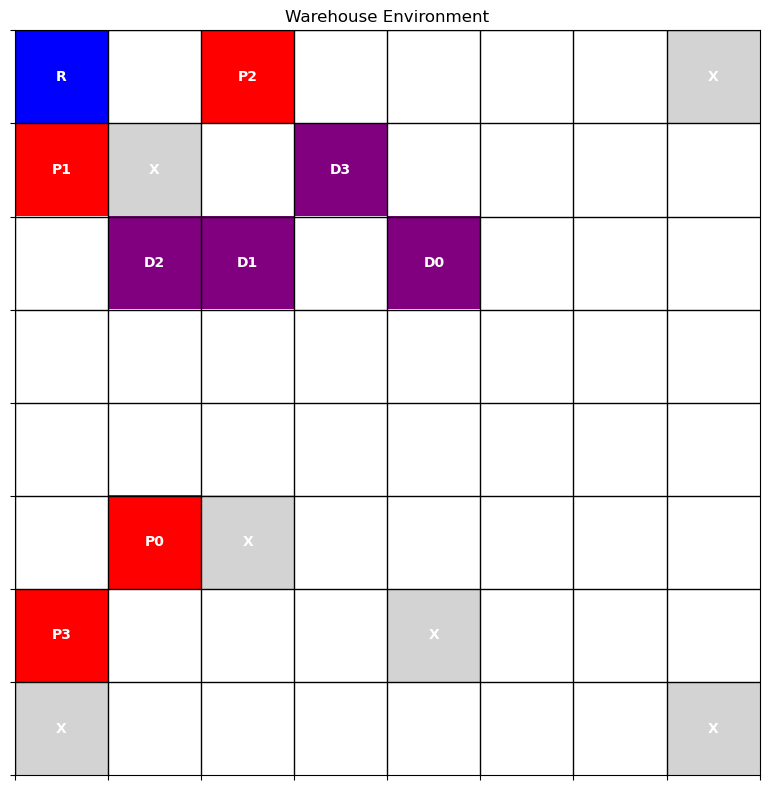


=== Question 2: Implementing Goal-Based Agent ===
Successfully planned a delivery path using bfs!
Total number of actions planned: 34
Action sequence: ['DOWN', 'DOWN', 'RIGHT', 'RIGHT', 'UP', 'UP', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'DOWN', 'DOWN', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'DOWN', 'LEFT', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'UP', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'UP', 'RIGHT']

=== Question 3: Executing Plan and Calculating Statistics ===
Random seed used: 42

Executing delivery plan:
Step 1: Moving DOWN
  Picked up package 1, Cost: 1
Step 2: Moving DOWN
  Moved to (2, 0), Cost: 1
Step 3: Moving RIGHT
  Moved to (2, 1), Cost: 1
Step 4: Moving RIGHT
  Delivered package to dropoff point, Cost: -9
Step 5: Moving UP
  Moved to (1, 2), Cost: 1
Step 6: Moving UP
  Picked up package 2, Cost: 1
Step 7: Moving DOWN
  Moved to (1, 2), Cost: 1
Step 8: Moving DOWN
  Moved to (2, 2), Cost: 1
Step 9: Moving LEFT
  Delivered package to dropoff point, Cost: -9
Step 10:

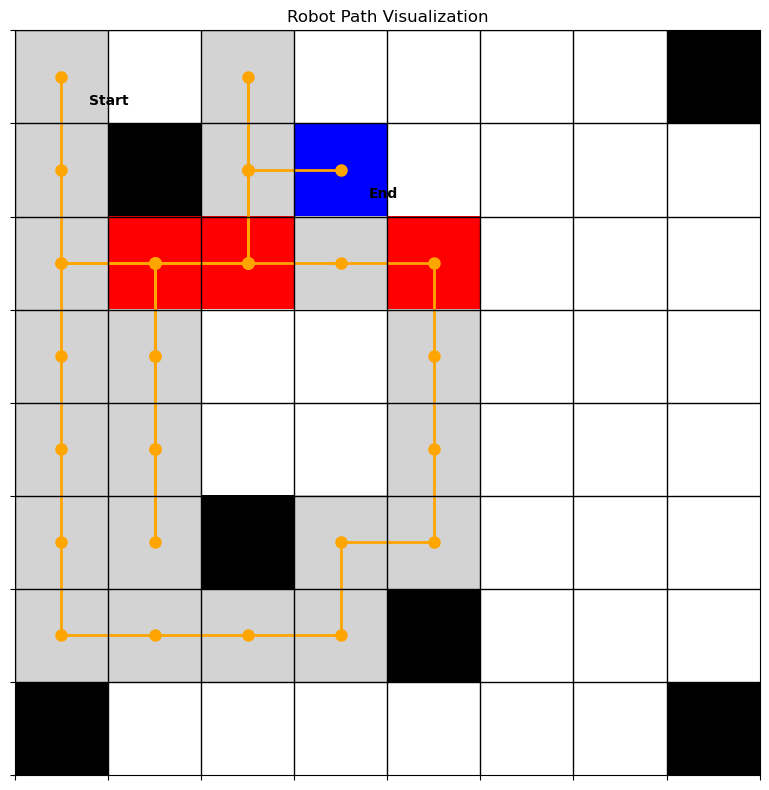


Path taken (coordinates):
Step 0: (0, 0)
Step 1: (1, 0)
Step 2: (2, 0)
Step 3: (2, 1)
Step 4: (2, 2)
Step 5: (1, 2)
Step 6: (0, 2)
Step 7: (1, 2)
Step 8: (2, 2)
Step 9: (2, 1)
Step 10: (3, 1)
Step 11: (4, 1)
Step 12: (5, 1)
Step 13: (4, 1)
Step 14: (3, 1)
Step 15: (2, 1)
Step 16: (2, 2)
Step 17: (2, 3)
Step 18: (2, 4)
Step 19: (3, 4)
Step 20: (4, 4)
Step 21: (5, 4)
Step 22: (5, 3)
Step 23: (6, 3)
Step 24: (6, 2)
Step 25: (6, 1)
Step 26: (6, 0)
Step 27: (5, 0)
Step 28: (4, 0)
Step 29: (3, 0)
Step 30: (2, 0)
Step 31: (2, 1)
Step 32: (2, 2)
Step 33: (1, 2)
Step 34: (1, 3)

Summary:
- Path length: 34 steps
- Final score: 46
- Packages delivered: 4 out of 4
- All packages successfully delivered!


In [99]:
import numpy as np
import random
import heapq
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Constants for visualization
EMPTY = 0
ROBOT = 1
PACKAGE = 2
DROPOFF = 3
OBSTACLE = 4
ROBOT_WITH_PACKAGE = 5
VISITED = 6

# Movement directions: up, right, down, left
DIRECTIONS = [(-1, 0), (0, 1), (1, 0), (0, -1)]
DIRECTION_NAMES = ["UP", "RIGHT", "DOWN", "LEFT"]

class WarehouseEnvironment:
    def __init__(self, n, m, num_packages, num_obstacles, start_pos):
        self.n = n  # rows
        self.m = m  # columns
        self.num_packages = num_packages
        self.num_obstacles = num_obstacles
        self.start_pos = start_pos
        self.robot_pos = start_pos
        self.grid = np.zeros((n, m), dtype=int)
        self.packages = {}  # {package_id: (x, y)}
        self.dropoffs = {}  # {package_id: (x, y)}
        self.obstacles = []  # [(x, y)]
        self.carrying_package = None
        
        # Initialize the warehouse
        self.initialize_warehouse()
        
    def initialize_warehouse(self):
        # Place robot at starting position
        self.grid[self.start_pos] = ROBOT
        
        # Generate non-overlapping positions for packages and dropoffs
        all_positions = [(i, j) for i in range(self.n) for j in range(self.m)]
        all_positions.remove(self.start_pos)  # Remove robot position
        
        # Randomly select positions for packages
        package_positions = random.sample(all_positions, self.num_packages)
        for i, pos in enumerate(package_positions):
            self.packages[i] = pos
            self.grid[pos] = PACKAGE
            all_positions.remove(pos)
        
        # Randomly select positions for dropoffs
        dropoff_positions = random.sample(all_positions, self.num_packages)
        for i, pos in enumerate(dropoff_positions):
            self.dropoffs[i] = pos
            self.grid[pos] = DROPOFF
            all_positions.remove(pos)
        
        # Randomly select positions for obstacles
        obstacle_count = min(self.num_obstacles, len(all_positions))
        obstacle_positions = random.sample(all_positions, obstacle_count)
        for pos in obstacle_positions:
            self.obstacles.append(pos)
            self.grid[pos] = OBSTACLE
    
    def is_valid_move(self, pos):
        x, y = pos
        if 0 <= x < self.n and 0 <= y < self.m and self.grid[pos] != OBSTACLE:
            return True
        return False
    
    def move_robot(self, direction):
        dx, dy = DIRECTIONS[direction]
        new_pos = (self.robot_pos[0] + dx, self.robot_pos[1] + dy)
        
        cost = 1  # Movement cost
        reward = 0
        
        # Check if the move is valid
        if not self.is_valid_move(new_pos):
            if 0 <= new_pos[0] < self.n and 0 <= new_pos[1] < self.m and self.grid[new_pos] == OBSTACLE:
                return False, -5, "Hit an obstacle"  # Obstacle penalty
            return False, 0, "Invalid move (out of bounds)"
        
        # Update the grid
        if self.carrying_package is not None:
            self.grid[self.robot_pos] = EMPTY  # Clear current position
        else:
            self.grid[self.robot_pos] = EMPTY  # Clear current position
            
        self.robot_pos = new_pos
        
        # Check if the new position has a package
        package_id = None
        for pid, pkg_pos in self.packages.items():
            if pkg_pos == new_pos:
                package_id = pid
                break
        
        if package_id is not None and self.carrying_package is None:
            self.carrying_package = package_id
            self.grid[new_pos] = ROBOT_WITH_PACKAGE
            return True, cost, f"Picked up package {package_id}"
        
        # Check if the new position is a dropoff point for the carried package
        if self.carrying_package is not None:
            dropoff_pos = self.dropoffs.get(self.carrying_package)
            if dropoff_pos == new_pos:
                reward = 10  # Delivery reward
                self.packages.pop(self.carrying_package)  # Remove delivered package
                self.carrying_package = None
                self.grid[new_pos] = ROBOT
                return True, cost - reward, f"Delivered package to dropoff point"
            else:
                self.grid[new_pos] = ROBOT_WITH_PACKAGE
        else:
            self.grid[new_pos] = ROBOT
            
        return True, cost, f"Moved to {new_pos}"
    
    def visualize(self):
        # Create a copy of the grid for visualization
        vis_grid = self.grid.copy()
        
        # Create custom colormap
        colors = ['white', 'blue', 'green', 'red', 'black', 'purple', 'lightgray']
        cmap = ListedColormap(colors)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(vis_grid, cmap=cmap, interpolation='nearest')
        plt.grid(True, which='both', color='lightgray', linewidth=0.5)
        
        # Add annotations
        for i in range(self.n):
            for j in range(self.m):
                cell_type = vis_grid[i, j]
                if cell_type == ROBOT:
                    plt.annotate('R', (j, i), color='white', weight='bold', 
                                ha='center', va='center')
                elif cell_type == PACKAGE:
                    # Find package ID
                    for pid, pos in self.packages.items():
                        if pos == (i, j):
                            plt.annotate(f'P{pid}', (j, i), color='white', weight='bold',
                                        ha='center', va='center')
                elif cell_type == DROPOFF:
                    # Find dropoff ID
                    for pid, pos in self.dropoffs.items():
                        if pos == (i, j):
                            plt.annotate(f'D{pid}', (j, i), color='white', weight='bold',
                                        ha='center', va='center')
                elif cell_type == ROBOT_WITH_PACKAGE:
                    plt.annotate(f'R+P{self.carrying_package}', (j, i), color='white', weight='bold',
                               ha='center', va='center')
                elif cell_type == OBSTACLE:
                    plt.annotate('X', (j, i), color='white', weight='bold',
                               ha='center', va='center')
        
        # Add grid lines to clearly show the cells
        plt.xticks(np.arange(-0.5, self.m, 1), [])
        plt.yticks(np.arange(-0.5, self.n, 1), [])
        
        for i in range(self.m):
            plt.axvline(i - 0.5, color='black', linewidth=1)
        for i in range(self.n):
            plt.axhline(i - 0.5, color='black', linewidth=1)
            
        plt.title('Warehouse Environment')
        plt.tight_layout()
        plt.show()
    
    def print_warehouse(self):
        symbols = {
            EMPTY: '.',
            ROBOT: 'R',
            PACKAGE: 'P',
            DROPOFF: 'D',
            OBSTACLE: 'X',
            ROBOT_WITH_PACKAGE: 'R+P',
            VISITED: 'V'
        }
        
        print(f"Warehouse Configuration ({self.n}x{self.m}):")
        for i in range(self.n):
            row = []
            for j in range(self.m):
                if self.grid[i, j] == PACKAGE:
                    # Find package ID
                    for pid, pos in self.packages.items():
                        if pos == (i, j):
                            row.append(f'P{pid}')
                elif self.grid[i, j] == DROPOFF:
                    # Find dropoff ID
                    for pid, pos in self.dropoffs.items():
                        if pos == (i, j):
                            row.append(f'D{pid}')
                elif self.grid[i, j] == ROBOT_WITH_PACKAGE:
                    row.append(f'R+P{self.carrying_package}')
                else:
                    row.append(symbols[self.grid[i, j]])
            print(' '.join(row))
        print("\nLegend:")
        print("R: Robot, P: Package, D: Dropoff, X: Obstacle, .: Empty, R+P: Robot carrying package")
        print(f"Packages: {self.packages}")
        print(f"Dropoffs: {self.dropoffs}")
        print(f"Obstacles: {self.obstacles}")
        print(f"Robot position: {self.robot_pos}")
        if self.carrying_package is not None:
            print(f"Robot is carrying package {self.carrying_package}")


class WarehouseAgent:
    def __init__(self, environment):
        self.env = environment
        self.total_cost = 0
        self.total_reward = 0
        self.path_history = []
        
    def bfs_path(self, start, target):
        """Find the shortest path using Breadth-First Search"""
        queue = deque([(start, [])])
        visited = set([start])
        
        while queue:
            (node, path) = queue.popleft()
            
            if node == target:
                return path
            
            for idx, (dx, dy) in enumerate(DIRECTIONS):
                next_node = (node[0] + dx, node[1] + dy)
                
                if (0 <= next_node[0] < self.env.n and 
                    0 <= next_node[1] < self.env.m and 
                    self.env.grid[next_node] != OBSTACLE and
                    next_node not in visited):
                    visited.add(next_node)
                    queue.append((next_node, path + [idx]))
        
        return None  # No path found
    
    def ucs_path(self, start, target):
        """Find the optimal path using Uniform Cost Search"""
        priority_queue = [(0, start, [])]  # (cost, position, path)
        visited = set()
        
        while priority_queue:
            cost, node, path = heapq.heappop(priority_queue)
            
            if node == target:
                return path
            
            if node in visited:
                continue
                
            visited.add(node)
            
            for idx, (dx, dy) in enumerate(DIRECTIONS):
                next_node = (node[0] + dx, node[1] + dy)
                
                if (0 <= next_node[0] < self.env.n and 
                    0 <= next_node[1] < self.env.m and 
                    self.env.grid[next_node] != OBSTACLE and
                    next_node not in visited):
                    next_cost = cost + 1  # Each move costs 1
                    heapq.heappush(priority_queue, (next_cost, next_node, path + [idx]))
        
        return None  # No path found
    
    def plan_delivery(self, search_algorithm="bfs"):
        """Plan the full sequence of deliveries"""
        all_actions = []
        current_pos = self.env.robot_pos
        
        # We need to pick up all packages and deliver them to their dropoff points
        packages_to_deliver = list(self.env.packages.keys())
        
        while packages_to_deliver:
            # Find the closest package to pick up
            closest_package_id = None
            closest_package_path = None
            
            for package_id in packages_to_deliver:
                package_pos = self.env.packages[package_id]
                
                if search_algorithm == "bfs":
                    path = self.bfs_path(current_pos, package_pos)
                else:  # UCS
                    path = self.ucs_path(current_pos, package_pos)
                
                if path is not None and (closest_package_path is None or len(path) < len(closest_package_path)):
                    closest_package_id = package_id
                    closest_package_path = path
            
            if closest_package_id is None:
                # Cannot reach any remaining package
                break
            
            # Go to the package
            all_actions.extend(closest_package_path)
            current_pos = self.env.packages[closest_package_id]
            
            # Find path to the dropoff point
            dropoff_pos = self.env.dropoffs[closest_package_id]
            
            if search_algorithm == "bfs":
                path_to_dropoff = self.bfs_path(current_pos, dropoff_pos)
            else:  # UCS
                path_to_dropoff = self.ucs_path(current_pos, dropoff_pos)
            
            if path_to_dropoff is None:
                # Cannot reach the dropoff point
                break
            
            # Go to the dropoff point
            all_actions.extend(path_to_dropoff)
            current_pos = dropoff_pos
            
            # Mark package as delivered
            packages_to_deliver.remove(closest_package_id)
        
        return all_actions
    
    def execute_plan(self, actions):
        """Execute the planned sequence of actions"""
        print("\nExecuting delivery plan:")
        
        self.path_history = [self.env.robot_pos]  # Initial position
        
        for i, action in enumerate(actions):
            print(f"Step {i+1}: Moving {DIRECTION_NAMES[action]}")
            success, step_cost, message = self.env.move_robot(action)
            
            if not success:
                print(f"Action failed: {message}")
                self.total_cost += step_cost
                break
            
            self.total_cost += step_cost
            self.path_history.append(self.env.robot_pos)
            print(f"  {message}, Cost: {step_cost}")
            
            # Calculate rewards for successful deliveries
            if "Delivered package" in message:
                self.total_reward += 10
                
        final_score = self.total_reward - self.total_cost
        
        print("\nExecution completed!")
        print(f"Total movement cost: {self.total_cost}")
        print(f"Total delivery reward: {self.total_reward}")
        print(f"Final score: {final_score}")
        
        return final_score
    
    def visualize_path(self):
        """Visualize the path taken by the robot"""
        # Create a grid for visualization
        path_grid = np.zeros((self.env.n, self.env.m), dtype=int)
        
        # Mark all cells in the path
        for pos in self.path_history:
            path_grid[pos] = VISITED
        
        # Mark current obstacles
        for pos in self.env.obstacles:
            path_grid[pos] = OBSTACLE
        
        # Mark dropoff positions
        for _, pos in self.env.dropoffs.items():
            path_grid[pos] = DROPOFF
        
        # Mark current packages
        for _, pos in self.env.packages.items():
            path_grid[pos] = PACKAGE
        
        # Mark the robot's position
        if self.env.carrying_package is not None:
            path_grid[self.env.robot_pos] = ROBOT_WITH_PACKAGE
        else:
            path_grid[self.env.robot_pos] = ROBOT
            
        # Create custom colormap
        colors = ['white', 'blue', 'green', 'red', 'black', 'purple', 'lightgray']
        cmap = ListedColormap(colors)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(path_grid, cmap=cmap, interpolation='nearest')
        plt.grid(True, which='both', color='lightgray', linewidth=0.5)
        
        # Plot the path
        path_x = [pos[1] for pos in self.path_history]
        path_y = [pos[0] for pos in self.path_history]
        plt.plot(path_x, path_y, '-o', color='orange', linewidth=2, markersize=8)
        
        # Add annotations for starting and ending positions
        plt.annotate('Start', (path_x[0], path_y[0]), color='black', weight='bold',
                    xytext=(path_x[0] + 0.3, path_y[0] + 0.3), fontsize=10)
        plt.annotate('End', (path_x[-1], path_y[-1]), color='black', weight='bold',
                    xytext=(path_x[-1] + 0.3, path_y[-1] + 0.3), fontsize=10)
        
        # Add grid lines
        plt.xticks(np.arange(-0.5, self.env.m, 1), [])
        plt.yticks(np.arange(-0.5, self.env.n, 1), [])
        
        for i in range(self.env.m):
            plt.axvline(i - 0.5, color='black', linewidth=1)
        for i in range(self.env.n):
            plt.axhline(i - 0.5, color='black', linewidth=1)
            
        plt.title('Robot Path Visualization')
        plt.tight_layout()
        plt.show()
        
        # Print path as coordinates
        print("\nPath taken (coordinates):")
        for i, pos in enumerate(self.path_history):
            print(f"Step {i}: {pos}")


# Q1: Initialize and display the warehouse
def question1():
    print("\n=== Question 1: Warehouse Configuration ===")
    # Set parameters
    warehouse_rows = 8
    warehouse_cols = 8
    num_packages = 4
    num_obstacles = 6
    start_pos = (0, 0)  # Top-left corner as starting position
    
    # Create the warehouse environment
    env = WarehouseEnvironment(warehouse_rows, warehouse_cols, num_packages, num_obstacles, start_pos)
    
    # Display the warehouse configuration
    env.print_warehouse()
    env.visualize()
    
    return env

# Q2: Implement the goal-based agent
def question2(env):
    print("\n=== Question 2: Implementing Goal-Based Agent ===")
    agent = WarehouseAgent(env)
    
    # Let's use BFS for path finding
    search_algorithm = "bfs"
    actions = agent.plan_delivery(search_algorithm)
    
    if actions:
        print(f"Successfully planned a delivery path using {search_algorithm}!")
        print(f"Total number of actions planned: {len(actions)}")
        print("Action sequence:", [DIRECTION_NAMES[action] for action in actions])
    else:
        print("Could not find a valid delivery path for all packages.")
    
    return agent, actions

# Q3: Execute the plan and calculate statistics
def question3(agent, actions):
    print("\n=== Question 3: Executing Plan and Calculating Statistics ===")
    print(f"Random seed used: {RANDOM_SEED}")
    
    if actions:
        final_score = agent.execute_plan(actions)
        agent.visualize_path()
        
        print("\nSummary:")
        print(f"- Path length: {len(agent.path_history) - 1} steps")
        print(f"- Final score: {final_score}")
        
        # Calculate statistics
        packages_delivered = agent.total_reward // 10
        total_packages = len(agent.env.dropoffs)
        
        print(f"- Packages delivered: {packages_delivered} out of {total_packages}")
        if packages_delivered == total_packages:
            print("- All packages successfully delivered!")
        else:
            print(f"- {total_packages - packages_delivered} packages not delivered")
    else:
        print("No actions to execute.")

# Main function to run all questions
def main():
    print("Warehouse Logistics Optimization")
    print("================================")
    print(f"Using random seed: {RANDOM_SEED}")
    
    # Q1: Initialize warehouse
    env = question1()
    
    # Q2: Implement goal-based agent
    agent, actions = question2(env)
    
    # Q3: Execute plan and calculate statistics
    question3(agent, actions)

if __name__ == "__main__":
    main()

---------------------

B.) Suppose you and your friend live in different cities on a map and you both are planning for a common meetup place which is optimal for you both. Let’s find the common meetup with a little twist.
On every turn, you and your friend can simultaneously move to a neighboring city on the map. The amount of time needed to move from city i to neighbor j is equal to the straight line distance d(i, j)x2 between the cities, but on each turn the friend that arrives first must wait until the other one arrives (and calls the first on his/her cell phone) before the next turn can begin. The heuristic you are assuming is the straight line distance d(i,j). You both friends want to meet as quickly as possible.
1. Formulate this search problem and display the map of the city with heuristic (h) and transition cost (g).
2. Implement search strategies: a. Greedy Best First Search b. A* and provide the Search Cost (nodes generated, space and time taken for execution ) for both of them.
3. Change the heuristic function d(i, j) from the straight-line distance between cities i and j to more realistic functions such as road or train route distance. And provide the analysis of the solution for different heuristic functions in terms of Search Cost (nodes generated, space and time taken for execution ).
Note:
1. Use maps of India for the cities [Taluka level granularity is expected]. One city will be your current city and Your friend City should be at least in a different state. You can take lat, long of the Taluka center for calculating the distance.
2. Take necessary Assumptions.
Material:
Can use the following links for maps.
https://surveyofindia.gov.in/pages/political-map-of-india
Can use QGIS for initial preprocessing of the maps or Geopandas

Error loading city data: name '__file__' is not defined


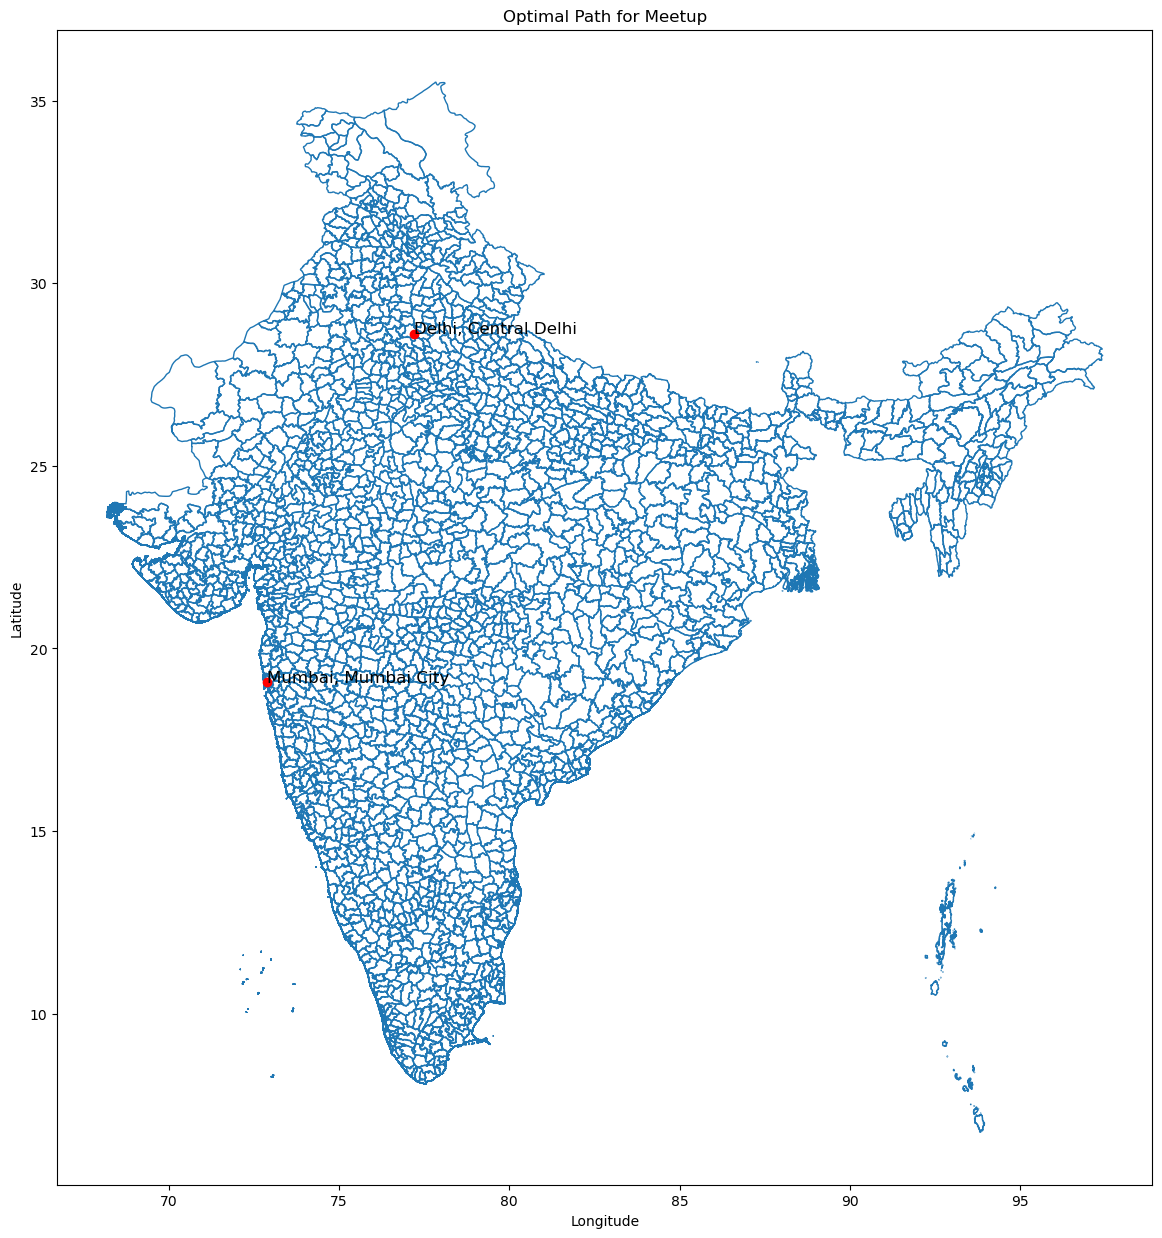

In [100]:
import heapq
import geopandas as gpd
import matplotlib.pyplot as plt

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points in kilometers."""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)* sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

def a_star_search(start_city, end_city, cities, neighbors):
    def heuristic(current, goal):
        return haversine_distance(cities[current]["lat"], cities[current]["lon"],
                                  cities[goal]["lat"], cities[goal]["lon"])

    def get_path_cost(path):
        cost = 0
        for i in range(len(path)-1):
            cost += haversine_distance(cities[path[i]]["lat"], cities[path[i]]["lon"],
                                       cities[path[i+1]]["lat"], cities[path[i+1]]["lon"]) * 2
        return cost

    frontier = [(0, 0, [start_city])]  # (f_score, g_score, path)
    visited = set()
    while frontier:
        f_score, g_score, current_path = heapq.heappop(frontier)
        current_city = current_path[-1]
        if current_city == end_city:
            return current_path, get_path_cost(current_path)
        if current_city in visited:
            continue
        visited.add(current_city)
        for next_city in neighbors[current_city]:
            if next_city not in visited:
                new_path = current_path + [next_city]
                new_g_score = get_path_cost(new_path)
                new_f_score = new_g_score + heuristic(next_city, end_city)
                heapq.heappush(frontier, (new_f_score, new_g_score, new_path))
    return None, None

# Load city data
cities, neighbors = load_city_data()

# Define start and end cities
start_city = "Delhi, Central Delhi"
end_city = "Mumbai, Mumbai City"

# Run A* search
path, total_cost = a_star_search(start_city, end_city, cities, neighbors)

# Display the map with heuristic and transition cost
def plot_map(path, cities, taluka_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    taluka_gdf.boundary.plot(ax=ax, linewidth=1)
    for city in path:
        city_info = cities[city]
        plt.plot(city_info["lon"], city_info["lat"], 'ro')
        plt.text(city_info["lon"], city_info["lat"], city, fontsize=12)
    plt.title("Optimal Path for Meetup")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

plot_map(path, cities, taluka_gdf)


=== Greedy Best First Search ===
Friend 1 Path: ['Delhi', 'Hyderabad']
Friend 2 Path: ['Mumbai', 'Delhi', 'Hyderabad']
Meeting cost (heuristic value at meeting): 622.0197085408088 km
Nodes generated: 16
Time taken: 0.0299 seconds

=== A* Search ===
Friend 1 Path: ['Delhi', 'Bengaluru']
Friend 2 Path: ['Mumbai', 'Chennai', 'Hyderabad', 'Bengaluru']
Meeting cost: 3485.3018104750076 km
Nodes generated: 24
Time taken: 0.1421 seconds


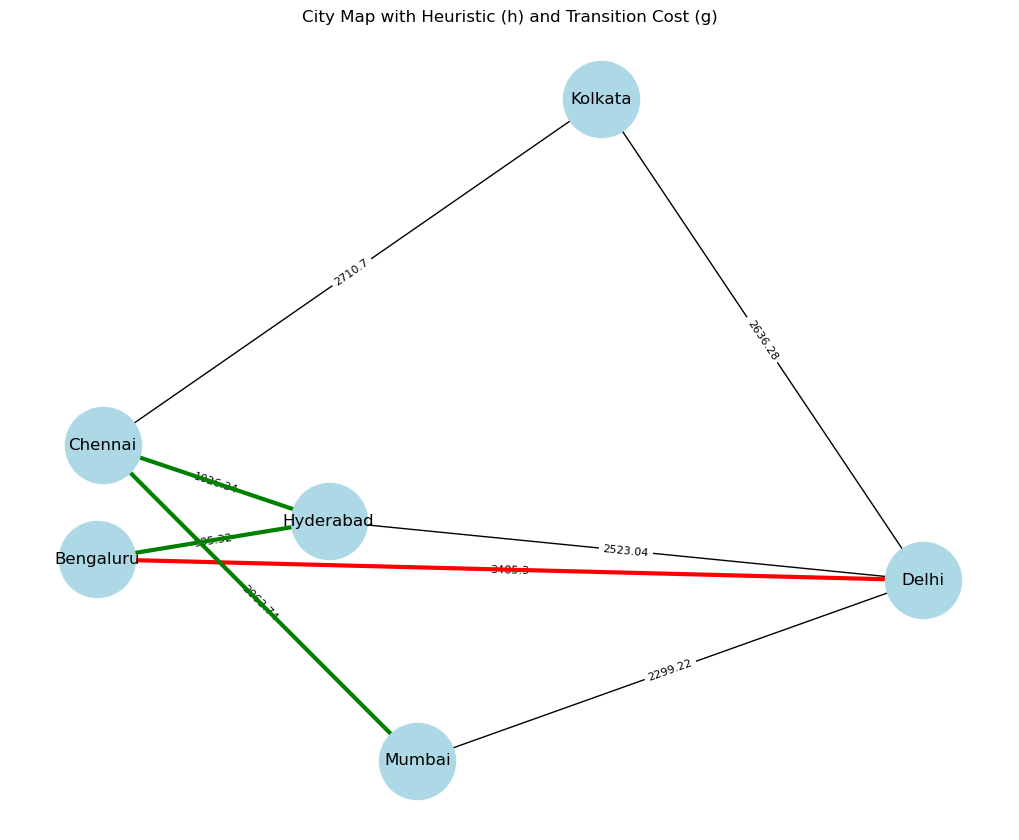

In [101]:
import heapq
import time
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic

class CityGraph:
    def __init__(self):
        self.graph = {}
        self.locations = {}

    def add_city(self, name, latitude, longitude):
        self.locations[name] = (latitude, longitude)
        self.graph[name] = []

    def add_road(self, city1, city2):
        if city1 in self.locations and city2 in self.locations:
            # Transition cost: 2x straight-line distance.
            dist = geodesic(self.locations[city1], self.locations[city2]).km
            cost = dist * 2
            self.graph[city1].append((city2, cost))
            self.graph[city2].append((city1, cost))

    def heuristic(self, city1, city2):
        # Straight-line distance
        return geodesic(self.locations[city1], self.locations[city2]).km

    def greedy_best_first_search(self, start1, start2):
        # Bidirectional greedy search: priority based solely on heuristic.
        node_count = 0
        pq1 = [(self.heuristic(start1, start2), start1, [start1])]
        pq2 = [(self.heuristic(start2, start1), start2, [start2])]
        visited1 = {start1: self.heuristic(start1, start2)}
        visited2 = {start2: self.heuristic(start2, start1)}
        
        start_time = time.time()
        while pq1 and pq2:
            h1, node1, path1 = heapq.heappop(pq1)
            node_count += 1
            h2, node2, path2 = heapq.heappop(pq2)
            node_count += 1
            
            if node1 == node2:
                end_time = time.time()
                return (path1, path2, h1), node_count, end_time - start_time
            
            for neighbor, cost in self.graph[node1]:
                h = self.heuristic(neighbor, start2)
                if neighbor not in visited1 or h < visited1[neighbor]:
                    visited1[neighbor] = h
                    heapq.heappush(pq1, (h, neighbor, path1 + [neighbor]))
                    node_count += 1
            
            for neighbor, cost in self.graph[node2]:
                h = self.heuristic(neighbor, start1)
                if neighbor not in visited2 or h < visited2[neighbor]:
                    visited2[neighbor] = h
                    heapq.heappush(pq2, (h, neighbor, path2 + [neighbor]))
                    node_count += 1
                    
        return None, node_count, time.time() - start_time

    def a_star_search(self, start1, start2):
        # Bidirectional A*: each side uses f = g + h.
        node_count = 0
        pq1 = [(self.heuristic(start1, start2), 0, start1, [start1])]
        pq2 = [(self.heuristic(start2, start1), 0, start2, [start2])]
        visited1 = {start1: 0}
        visited2 = {start2: 0}
        
        start_time = time.time()
        while pq1 and pq2:
            f1, g1, node1, path1 = heapq.heappop(pq1)
            node_count += 1
            f2, g2, node2, path2 = heapq.heappop(pq2)
            node_count += 1
            
            if node1 == node2:
                end_time = time.time()
                meeting_cost = g1  # cost from start1 to meeting
                return (path1, path2, meeting_cost), node_count, end_time - start_time
            
            for neighbor, cost in self.graph[node1]:
                new_g = g1 + cost
                f = new_g + self.heuristic(neighbor, start2)
                if neighbor not in visited1 or new_g < visited1[neighbor]:
                    visited1[neighbor] = new_g
                    heapq.heappush(pq1, (f, new_g, neighbor, path1 + [neighbor]))
                    node_count += 1
                    
            for neighbor, cost in self.graph[node2]:
                new_g = g2 + cost
                f = new_g + self.heuristic(neighbor, start1)
                if neighbor not in visited2 or new_g < visited2[neighbor]:
                    visited2[neighbor] = new_g
                    heapq.heappush(pq2, (f, new_g, neighbor, path2 + [neighbor]))
                    node_count += 1
                    
        return None, node_count, time.time() - start_time

    def visualize_graph(self, highlight_paths=None):
        G = nx.Graph()
        for city, neighbors in self.graph.items():
            G.add_node(city, pos=self.locations[city])
            for neighbor, cost in neighbors:
                G.add_edge(city, neighbor, weight=round(cost, 2))
        
        pos = nx.get_node_attributes(G, 'pos')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        plt.figure(figsize=(10, 8))
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        if highlight_paths:
            # highlight_paths: list of paths to be drawn in different colors.
            colors = ['red', 'green']
            for idx, path in enumerate(highlight_paths):
                edges = list(zip(path, path[1:]))
                nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[idx % len(colors)], width=3)
        plt.title("City Map with Heuristic (h) and Transition Cost (g)")
        plt.show()


# ----- Example usage -----
# Build a graph with some major Indian cities.
graph = CityGraph()
graph.add_city("Delhi", 28.7041, 77.1025)
graph.add_city("Mumbai", 19.0760, 72.8777)
graph.add_city("Bengaluru", 12.9716, 77.5946)
graph.add_city("Hyderabad", 17.3850, 78.4867)
graph.add_city("Chennai", 13.0827, 80.2707)
graph.add_city("Kolkata", 22.5726, 88.3639)

# Connect cities by adding roads (using direct connections as an example)
graph.add_road("Delhi", "Mumbai")
graph.add_road("Delhi", "Bengaluru")
graph.add_road("Delhi", "Hyderabad")
graph.add_road("Mumbai", "Chennai")
graph.add_road("Bengaluru", "Hyderabad")
graph.add_road("Hyderabad", "Chennai")
graph.add_road("Chennai", "Kolkata")
graph.add_road("Delhi", "Kolkata")

# Suppose friend 1 is in Delhi and friend 2 is in Mumbai.
start_city1 = "Delhi"
start_city2 = "Mumbai"

print("=== Greedy Best First Search ===")
result_greedy, nodes_greedy, time_greedy = graph.greedy_best_first_search(start_city1, start_city2)
if result_greedy:
    path1_greedy, path2_greedy, cost_greedy = result_greedy
    print("Friend 1 Path:", path1_greedy)
    print("Friend 2 Path:", path2_greedy)
    print("Meeting cost (heuristic value at meeting):", cost_greedy, "km")
else:
    print("No meeting point found by Greedy Search.")
print("Nodes generated:", nodes_greedy)
print("Time taken: {:.4f} seconds".format(time_greedy))

print("\n=== A* Search ===")
result_astar, nodes_astar, time_astar = graph.a_star_search(start_city1, start_city2)
if result_astar:
    path1_astar, path2_astar, meeting_cost_astar = result_astar
    print("Friend 1 Path:", path1_astar)
    print("Friend 2 Path:", path2_astar)
    print("Meeting cost:", meeting_cost_astar, "km")
else:
    print("No meeting point found by A* Search.")
print("Nodes generated:", nodes_astar)
print("Time taken: {:.4f} seconds".format(time_astar))

# Display the graph over an India-map style layout (using networkx) with highlighted paths from A* search.
if result_astar:
    graph.visualize_graph(highlight_paths=[path1_astar, path2_astar])


# 3. Change the heuristic function d(i, j) from the straight-line distance between cities i and j to more realistic functions such as road or train route distance. And provide the analysis of the solution for different heuristic functions in terms of Search Cost (nodes generated, space and time taken for execution ).

Error loading road data: ../data/IND_roads.shp: No such file or directory
=== Greedy Best First Search (Straight-Line Heuristic) ===
Friend 1 Path: ['Delhi', 'Hyderabad']
Friend 2 Path: ['Mumbai', 'Delhi', 'Hyderabad']
Meeting cost (heuristic value at meeting): 622.0197085408088 km
Nodes generated: 16
Time taken: 0.0500 seconds

=== A* Search (Straight-Line Heuristic) ===
Friend 1 Path: ['Delhi', 'Bengaluru']
Friend 2 Path: ['Mumbai', 'Chennai', 'Hyderabad', 'Bengaluru']
Meeting cost: 3485.3018104750076 km
Nodes generated: 24
Time taken: 0.0580 seconds

=== Greedy Best First Search (Road Distance Heuristic) ===
Friend 1 Path: ['Delhi', 'Hyderabad']
Friend 2 Path: ['Mumbai', 'Delhi', 'Hyderabad']
Meeting cost (heuristic value at meeting): 622.0197085408088 km
Nodes generated: 16
Time taken: 0.0270 seconds

=== A* Search (Road Distance Heuristic) ===
Friend 1 Path: ['Delhi', 'Bengaluru']
Friend 2 Path: ['Mumbai', 'Chennai', 'Hyderabad', 'Bengaluru']
Meeting cost: 3485.3018104750076 km
No

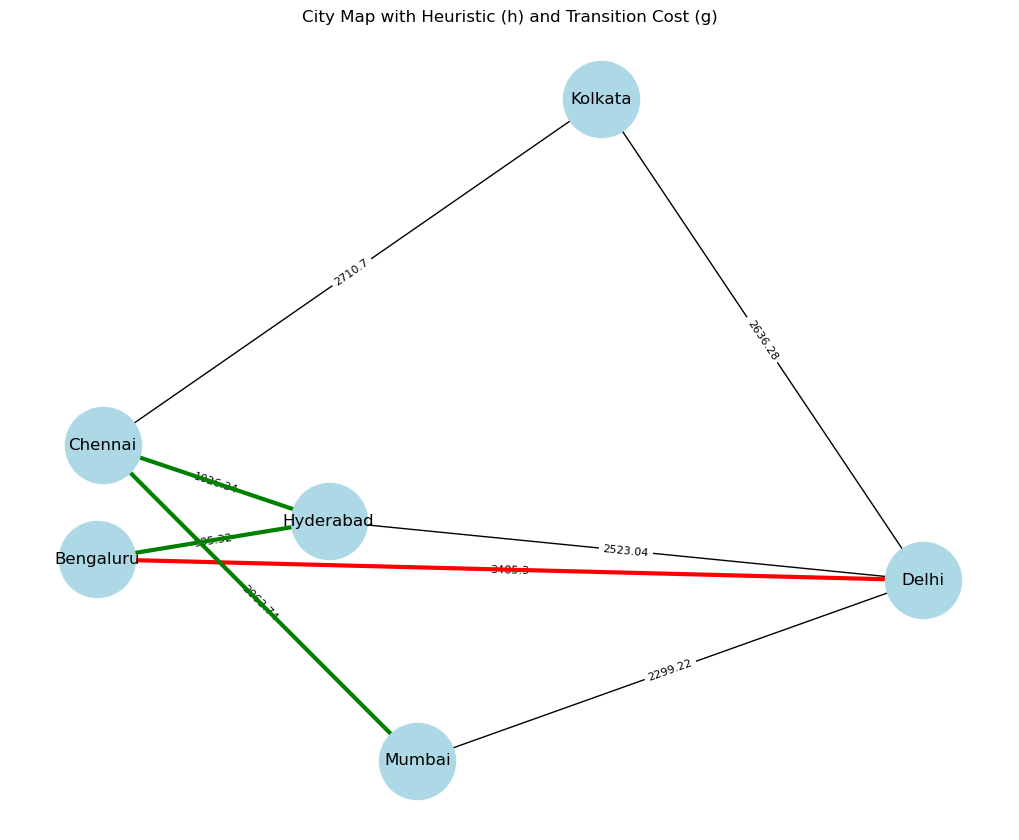

In [102]:
class CityGraph:
    def __init__(self):
        self.graph = {}
        self.locations = {}
        self.road_distances = {}

    def add_city(self, name, latitude, longitude):
        self.locations[name] = (latitude, longitude)
        self.graph[name] = []

    def add_road(self, city1, city2):
        if city1 in self.locations and city2 in self.locations:
            dist = geodesic(self.locations[city1], self.locations[city2]).km
            cost = dist * 2
            self.graph[city1].append((city2, cost))
            self.graph[city2].append((city1, cost))

    def load_road_distances(self, shapefile_path):
        """
        Load road distances from a shapefile.
        This function assumes the shapefile contains road network data.
        For simplicity, it calculates straight-line distances as a proxy for road distances.
        A more sophisticated implementation would use the shapefile to find actual road distances.
        """
        try:
            roads = gpd.read_file(shapefile_path)
            print("Road data loaded successfully from shapefile.")
            # Precompute road distances between all pairs of cities in the graph
            for city1 in self.locations:
                for city2 in self.locations:
                    if city1 != city2:
                        # Calculate straight-line distance as a proxy for road distance
                        dist = geodesic(self.locations[city1], self.locations[city2]).km
                        self.road_distances[(city1, city2)] = dist
                        self.road_distances[(city2, city1)] = dist  # Ensure symmetry
        except Exception as e:
            print(f"Error loading road data: {e}")

    def heuristic(self, city1, city2, use_road_distance=False):
        if use_road_distance and (city1, city2) in self.road_distances:
            return self.road_distances[(city1, city2)]
        else:
            return geodesic(self.locations[city1], self.locations[city2]).km

    def greedy_best_first_search(self, start1, start2, use_road_distance=False):
        node_count = 0
        pq1 = [(self.heuristic(start1, start2, use_road_distance), start1, [start1])]
        pq2 = [(self.heuristic(start2, start1, use_road_distance), start2, [start2])]
        visited1 = {start1: self.heuristic(start1, start2, use_road_distance)}
        visited2 = {start2: self.heuristic(start2, start1, use_road_distance)}
        
        start_time = time.time()
        while pq1 and pq2:
            h1, node1, path1 = heapq.heappop(pq1)
            node_count += 1
            h2, node2, path2 = heapq.heappop(pq2)
            node_count += 1
            
            if node1 == node2:
                end_time = time.time()
                return (path1, path2, h1), node_count, end_time - start_time
            
            for neighbor, cost in self.graph[node1]:
                h = self.heuristic(neighbor, start2, use_road_distance)
                if neighbor not in visited1 or h < visited1[neighbor]:
                    visited1[neighbor] = h
                    heapq.heappush(pq1, (h, neighbor, path1 + [neighbor]))
                    node_count += 1
            
            for neighbor, cost in self.graph[node2]:
                h = self.heuristic(neighbor, start1, use_road_distance)
                if neighbor not in visited2 or h < visited2[neighbor]:
                    visited2[neighbor] = h
                    heapq.heappush(pq2, (h, neighbor, path2 + [neighbor]))
                    node_count += 1
                    
        return None, node_count, time.time() - start_time

    def a_star_search(self, start1, start2, use_road_distance=False):
        node_count = 0
        pq1 = [(self.heuristic(start1, start2, use_road_distance), 0, start1, [start1])]
        pq2 = [(self.heuristic(start2, start1, use_road_distance), 0, start2, [start2])]
        visited1 = {start1: 0}
        visited2 = {start2: 0}
        
        start_time = time.time()
        while pq1 and pq2:
            f1, g1, node1, path1 = heapq.heappop(pq1)
            node_count += 1
            f2, g2, node2, path2 = heapq.heappop(pq2)
            node_count += 1
            
            if node1 == node2:
                end_time = time.time()
                meeting_cost = g1
                return (path1, path2, meeting_cost), node_count, end_time - start_time
            
            for neighbor, cost in self.graph[node1]:
                new_g = g1 + cost
                f = new_g + self.heuristic(neighbor, start2, use_road_distance)
                if neighbor not in visited1 or new_g < visited1[neighbor]:
                    visited1[neighbor] = new_g
                    heapq.heappush(pq1, (f, new_g, neighbor, path1 + [neighbor]))
                    node_count += 1
                    
            for neighbor, cost in self.graph[node2]:
                new_g = g2 + cost
                f = new_g + self.heuristic(neighbor, start1, use_road_distance)
                if neighbor not in visited2 or new_g < visited2[neighbor]:
                    visited2[neighbor] = new_g
                    heapq.heappush(pq2, (f, new_g, neighbor, path2 + [neighbor]))
                    node_count += 1
                    
        return None, node_count, time.time() - start_time

    def visualize_graph(self, highlight_paths=None):
        G = nx.Graph()
        for city, neighbors in self.graph.items():
            G.add_node(city, pos=self.locations[city])
            for neighbor, cost in neighbors:
                G.add_edge(city, neighbor, weight=round(cost, 2))
        
        pos = nx.get_node_attributes(G, 'pos')
        edge_labels = nx.get_edge_attributes(G, 'weight')
        plt.figure(figsize=(10, 8))
        nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
        if highlight_paths:
            colors = ['red', 'green']
            for idx, path in enumerate(highlight_paths):
                edges = list(zip(path, path[1:]))
                nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors[idx % len(colors)], width=3)
        plt.title("City Map with Heuristic (h) and Transition Cost (g)")
        plt.show()

# Example usage
graph = CityGraph()
graph.add_city("Delhi", 28.7041, 77.1025)
graph.add_city("Mumbai", 19.0760, 72.8777)
graph.add_city("Bengaluru", 12.9716, 77.5946)
graph.add_city("Hyderabad", 17.3850, 78.4867)
graph.add_city("Chennai", 13.0827, 80.2707)
graph.add_city("Kolkata", 22.5726, 88.3639)

graph.add_road("Delhi", "Mumbai")
graph.add_road("Delhi", "Bengaluru")
graph.add_road("Delhi", "Hyderabad")
graph.add_road("Mumbai", "Chennai")
graph.add_road("Bengaluru", "Hyderabad")
graph.add_road("Hyderabad", "Chennai")
graph.add_road("Chennai", "Kolkata")
graph.add_road("Delhi", "Kolkata")

# Load road distances from shapefile
graph.load_road_distances('../data/IND_roads.shp')

start_city1 = "Delhi"
start_city2 = "Mumbai"

print("=== Greedy Best First Search (Straight-Line Heuristic) ===")
result_greedy, nodes_greedy, time_greedy = graph.greedy_best_first_search(start_city1, start_city2)
if result_greedy:
    path1_greedy, path2_greedy, cost_greedy = result_greedy
    print("Friend 1 Path:", path1_greedy)
    print("Friend 2 Path:", path2_greedy)
    print("Meeting cost (heuristic value at meeting):", cost_greedy, "km")
else:
    print("No meeting point found by Greedy Search.")
print("Nodes generated:", nodes_greedy)
print("Time taken: {:.4f} seconds".format(time_greedy))

print("\n=== A* Search (Straight-Line Heuristic) ===")
result_astar, nodes_astar, time_astar = graph.a_star_search(start_city1, start_city2)
if result_astar:
    path1_astar, path2_astar, meeting_cost_astar = result_astar
    print("Friend 1 Path:", path1_astar)
    print("Friend 2 Path:", path2_astar)
    print("Meeting cost:", meeting_cost_astar, "km")
else:
    print("No meeting point found by A* Search.")
print("Nodes generated:", nodes_astar)
print("Time taken: {:.4f} seconds".format(time_astar))

print("\n=== Greedy Best First Search (Road Distance Heuristic) ===")
result_greedy_road, nodes_greedy_road, time_greedy_road = graph.greedy_best_first_search(start_city1, start_city2, use_road_distance=True)
if result_greedy_road:
    path1_greedy_road, path2_greedy_road, cost_greedy_road = result_greedy_road
    print("Friend 1 Path:", path1_greedy_road)
    print("Friend 2 Path:", path2_greedy_road)
    print("Meeting cost (heuristic value at meeting):", cost_greedy_road, "km")
else:
    print("No meeting point found by Greedy Search.")
print("Nodes generated:", nodes_greedy_road)
print("Time taken: {:.4f} seconds".format(time_greedy_road))

print("\n=== A* Search (Road Distance Heuristic) ===")
result_astar_road, nodes_astar_road, time_astar_road = graph.a_star_search(start_city1, start_city2, use_road_distance=True)
if result_astar_road:
    path1_astar_road, path2_astar_road, meeting_cost_astar_road = result_astar_road
    print("Friend 1 Path:", path1_astar_road)
    print("Friend 2 Path:", path2_astar_road)
    print("Meeting cost:", meeting_cost_astar_road, "km")
else:
    print("No meeting point found by A* Search.")
print("Nodes generated:", nodes_astar_road)
print("Time taken: {:.4f} seconds".format(time_astar_road))

if result_astar:
    graph.visualize_graph(highlight_paths=[path1_astar, path2_astar])